In [123]:
import pandas as pd
import numpy as np
from datetime import datetime
import os
from matplotlib import pyplot

## Game  by game home team or visiter team win 

In [3]:
mainData = pd.read_csv(
    os.path.join("game_logs.csv"),
    nrows=40000 # just taking the first 10k rows for efficiency
)

C:\Users\amjad\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3165: DtypeWarning: Columns (12,14,19,20,81,83,93,94,95,96,97,98,100,105,106,108,109,111,112,114,115,117,118,120,121,123,124,126,127,129,130,132,133,135,136,138,139,141,142,144,145,147,148,150,151,153,154,156,157,160) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


In [4]:
mainData.head()

,date,number_of_game,day_of_week,v_name,v_league,v_game_number,h_name,h_league,h_game_number,v_score,...,h_player_7_name,h_player_7_def_pos,h_player_8_id,h_player_8_name,h_player_8_def_pos,h_player_9_id,h_player_9_name,h_player_9_def_pos,additional_info,acquisition_info
0,18710504,0,5,CL1,na,1,FW1,na,1,0,...,Ed Mincher,7.0,mcdej101,James McDermott,8.0,kellb105,Bill Kelly,9.0,NaN,Y
1,18710505,0,6,BS1,na,1,WS3,na,1,20,...,Asa Brainard,1.0,burrh101,Henry Burroughs,9.0,berth101,Henry Berthrong,8.0,HTBF,Y
2,18710506,0,7,CL1,na,2,RC1,na,1,12,...,Pony Sager,6.0,birdg101,George Bird,7.0,stirg101,Gat Stires,9.0,NaN,Y
3,18710508,0,2,CL1,na,3,CH1,na,1,12,...,Ed Duffy,6.0,pinke101,Ed Pinkham,5.0,zettg101,George Zettlein,1.0,NaN,Y
4,18710509,0,3,BS1,na,2,TRO,na,1,9,...,Steve Bellan,5.0,pikel101,Lip Pike,3.0,cravb101,Bill Craver,6.0,HTBF,Y


In [74]:
df = mainData[['date', 'day_of_week','v_game_number','h_game_number', 'v_score','h_score','length_outs','day_night',
               'attendance','length_minutes', 'v_at_bats','h_at_bats', 'v_hits', 'h_hits', 'v_doubles','h_doubles', 'v_triples','h_triples',
               'v_homeruns','h_homeruns','v_rbi','h_rbi', 'v_sacrifice_hits','h_sacrifice_hits','v_sacrifice_hits']].copy()

In [75]:
df.shape

(40000, 25)

In [76]:
df.dtypes

date                  int64
day_of_week           int64
v_game_number         int64
h_game_number         int64
v_score               int64
h_score               int64
length_outs         float64
day_night            object
attendance          float64
length_minutes      float64
v_at_bats           float64
h_at_bats           float64
v_hits              float64
h_hits              float64
v_doubles           float64
h_doubles           float64
v_triples           float64
h_triples           float64
v_homeruns          float64
h_homeruns          float64
v_rbi               float64
h_rbi               float64
v_sacrifice_hits    float64
h_sacrifice_hits    float64
v_sacrifice_hits    float64
dtype: object

In [77]:
# change date into datetime
# doing this step create a problem that it makes the data not fitted for the transformer! it make it 3d
#df['date'] = datetime.strptime('18710504', '%Y%m%d')
df['day_night'] = df['day_night'].replace(['D','N'],[1,0])

In [78]:
df[['day_night']]

,day_night
0,1.0
1,1.0
2,1.0
3,1.0
4,1.0
...,...
39995,1.0
39996,1.0
39997,1.0
39998,1.0


In [79]:
# calculate which column is greater than the other then if the visiting team win v=1, if the home team win h=0
df['vist_win'] = np.where(
    df['v_score'] >  df['h_score'], 1, 0)

In [80]:
df[['vist_win']]

,vist_win
0,0
1,1
2,1
3,0
4,1
...,...
39995,1
39996,0
39997,1
39998,0


In [81]:
df = df.replace([' ','NULL','na','(none)'],np.nan)

In [82]:
print(df.isin(['NaN']).mean())

date                0.0
day_of_week         0.0
v_game_number       0.0
h_game_number       0.0
v_score             0.0
h_score             0.0
length_outs         0.0
day_night           0.0
attendance          0.0
length_minutes      0.0
v_at_bats           0.0
h_at_bats           0.0
v_hits              0.0
h_hits              0.0
v_doubles           0.0
h_doubles           0.0
v_triples           0.0
h_triples           0.0
v_homeruns          0.0
h_homeruns          0.0
v_rbi               0.0
h_rbi               0.0
v_sacrifice_hits    0.0
h_sacrifice_hits    0.0
v_sacrifice_hits    0.0
vist_win            0.0
dtype: float64


C:\Users\amjad\anaconda3\lib\site-packages\numpy\lib\arraysetops.py:580: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


In [83]:
# drop any NaNs
df_2 = df.dropna()

In [84]:
df_2.shape

(4258, 26)

In [85]:
df_2.dtypes

date                  int64
day_of_week           int64
v_game_number         int64
h_game_number         int64
v_score               int64
h_score               int64
length_outs         float64
day_night           float64
attendance          float64
length_minutes      float64
v_at_bats           float64
h_at_bats           float64
v_hits              float64
h_hits              float64
v_doubles           float64
h_doubles           float64
v_triples           float64
h_triples           float64
v_homeruns          float64
h_homeruns          float64
v_rbi               float64
h_rbi               float64
v_sacrifice_hits    float64
h_sacrifice_hits    float64
v_sacrifice_hits    float64
vist_win              int32
dtype: object

## Modeling

In [167]:
#transformer
from sklearn.preprocessing import FunctionTransformer
from sklearn.pipeline import make_pipeline
from sklearn.pipeline import FeatureUnion
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import cross_validate
from sklearn.preprocessing import OrdinalEncoder
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import Binarizer, KBinsDiscretizer

In [87]:
#ML model
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer 
from sklearn.model_selection import TimeSeriesSplit
from sklearn.model_selection import cross_validate

from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB

In [152]:
features = df_2[[
    'date', 'day_of_week','v_game_number','h_game_number','length_outs'
    ,'attendance','length_minutes', 'v_at_bats','h_at_bats', 'v_hits', 'h_hits', 'v_doubles','h_doubles'
    ,'v_triples','h_triples','v_homeruns','h_homeruns','v_rbi','h_rbi', 'v_sacrifice_hits','h_sacrifice_hits'
    ,'v_sacrifice_hits'
]]

target = df_2[['vist_win']].values.ravel()

In [153]:
#remove zero-variance features
from sklearn.feature_selection import VarianceThreshold
   

constant_filter = VarianceThreshold(threshold=0)
constant_filter.fit(features)
constant_columns = [column for column in features.columns
              if column not in
X_train.columns[constant_filter.get_support()]]
X_test = constant_filter.transform(features)
for column in constant_columns:
     print("Removed ", column)

According to this function we remove day_night feature because it has zero influnce on the result

In [156]:
#figer out the best seven features
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif
    
fvalue_Best = SelectKBest(f_classif, k=7)
X_kbest = fvalue_Best.fit_transform(features, target)

In [158]:
print('Original number of features:', df_2.shape)
print('Reduced number of features:', X_kbest.shape)

Original number of features: (4258, 26)
Reduced number of features: (4258, 7)


In [172]:
#split the data
X_train, X_test, y_train, y_test = train_test_split(
    X_kbest, target, test_size=0.2
)

In [138]:
# feature selection function

def select_features(X_train, y_train, X_test):
# configure to select all features
    fs = SelectKBest(score_func=f_classif, k="all")
# learn relationship from training data
    fs.fit(X_train, y_train)
# transform train input data
    X_train_fs = fs.transform(X_train)
# transform test input data
    X_test_fs = fs.transform(X_test)
    return X_train_fs, X_test_fs, fs

In [160]:
X_train_fs, X_test_fs, fs = select_features(X_train, y_train, X_test)
# what are scores for the features
for i in range(len(fs.scores_)):
    print('Feature %d: %f' % (i, fs.scores_[i]))

Feature 0: 8.447363
Feature 1: 3.637146
Feature 2: 0.749579
Feature 3: 0.552412
Feature 4: 159.071264
Feature 5: 3.909022
Feature 6: 59.498147
Feature 7: 158.648639
Feature 8: 3.189681
Feature 9: 601.444668
Feature 10: 352.350397
Feature 11: 162.140644
Feature 12: 84.282503
Feature 13: 115.541770
Feature 14: 92.736201
Feature 15: 60.223067
Feature 16: 47.743026
Feature 17: 739.037017
Feature 18: 574.043016
Feature 19: 349.821305
Feature 20: 349.821305
Feature 21: 224.252568
Feature 22: 349.821305
Feature 23: 349.821305


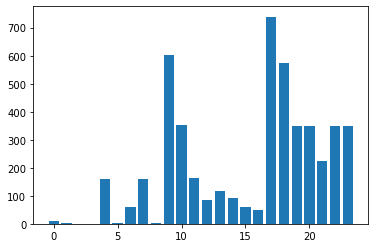

In [161]:
# plot the scores
pyplot.bar([i for i in range(len(fs.scores_))], fs.scores_)
pyplot.show()

In [163]:
from sklearn.metrics import accuracy_score
# fit the model
model = LogisticRegression(solver='liblinear')
model.fit(X_train_fs, y_train)
# evaluate the model
yhat = model.predict(X_test_fs)
# evaluate predictions
accuracy = accuracy_score(y_test, yhat)
print('Accuracy: %.2f' % (accuracy*100))

Accuracy: 53.99


Thought we have took the best features, logistic regression doesn't seems doing good

In [175]:
X_train.shape

(3406, 7)

In [176]:
y_train.shape

(3406,)

In [177]:
# Taking the best seven features and applying them to different ML models
model1 = Pipeline([
    ('impute', SimpleImputer(strategy="most_frequent")),
    ('clf', GaussianNB()),
])
cross_validate(model1, X_train, y_train, cv=TimeSeriesSplit(), scoring='f1_macro')


{'fit_time': array([0.00982237, 0.00498271, 0.00597429, 0.00598001, 0.00797272]),
 'score_time': array([0.0039835 , 0.00419426, 0.00199747, 0.00299001, 0.00199318]),
 'test_score': array([0.77482725, 0.72162957, 0.7445316 , 0.76957167, 0.7595667 ])}

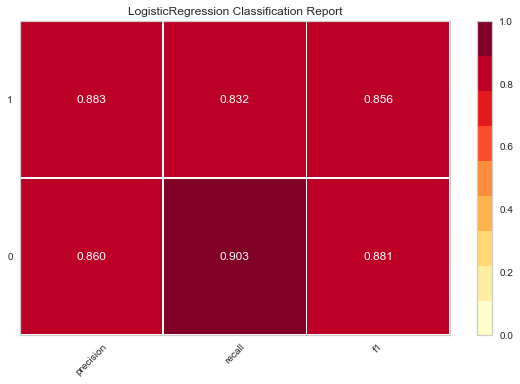

ClassificationReport(ax=<AxesSubplot:title={'center':'LogisticRegression Classification Report'}>,
                     cmap=<matplotlib.colors.ListedColormap object at 0x000001DD986AF7C0>,
                     estimator=Pipeline(steps=[('impute',
                                                SimpleImputer(strategy='most_frequent')),
                                               ('clf', LogisticRegression())]),
                     is_fitted=False)

In [193]:
classification_report(model1, X_train, y_train, X_test, y_test, is_fitted=False)

In [179]:
model2 = Pipeline([
    ('impute', SimpleImputer(strategy="most_frequent")),
    ('clf', SVC(kernel='rbf', degree=3)),
])
cross_validate(model2, X_train, y_train, cv=TimeSeriesSplit(), scoring='f1_macro')

{'fit_time': array([0.02295876, 0.04986978, 0.09636307, 0.17274117, 0.2534802 ]),
 'score_time': array([0.03389072, 0.04686785, 0.06484675, 0.08471775, 0.09903526]),
 'test_score': array([0.90364718, 0.8738398 , 0.89710372, 0.89065301, 0.89557613])}

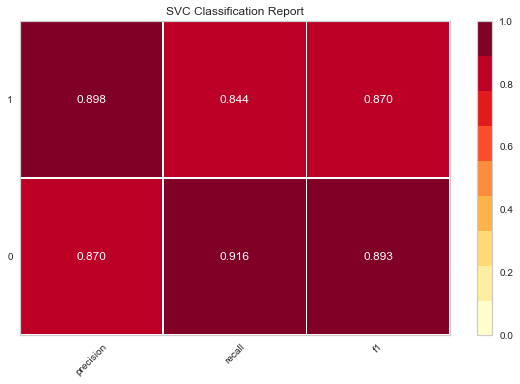

ClassificationReport(ax=<AxesSubplot:title={'center':'SVC Classification Report'}>,
                     cmap=<matplotlib.colors.ListedColormap object at 0x000001DD9559DD00>,
                     estimator=Pipeline(steps=[('impute',
                                                SimpleImputer(strategy='most_frequent')),
                                               ('clf', SVC())]),
                     is_fitted=False)

In [183]:
classification_report(model2, X_train, y_train, X_test, y_test, is_fitted=False)

In [184]:
model3 = Pipeline([
    ('impute', SimpleImputer(strategy="most_frequent")),
    ('clf', KNeighborsClassifier(n_neighbors=5)),
])
cross_validate(model3, X_train, y_train, cv=TimeSeriesSplit(), scoring='f1_macro')

{'fit_time': array([0.00898075, 0.00795221, 0.01003933, 0.01194596, 0.01496172]),
 'score_time': array([0.03824282, 0.03388762, 0.03823495, 0.03689694, 0.03683901]),
 'test_score': array([0.87124064, 0.85798259, 0.89588557, 0.87316355, 0.88706786])}

In [185]:
model4 = Pipeline([
    ('impute', SimpleImputer(strategy="most_frequent")),
    ('clf', LogisticRegression()),
])
cross_validate(model4, X_train, y_train, cv=TimeSeriesSplit(), scoring='f1_macro')

{'fit_time': array([0.02068329, 0.01694393, 0.03783917, 0.12235403, 0.05249715]),
 'score_time': array([0.00413966, 0.00298882, 0.00299311, 0.00299406, 0.00204444]),
 'test_score': array([0.90025683, 0.86995413, 0.88489063, 0.8895362 , 0.89557613])}

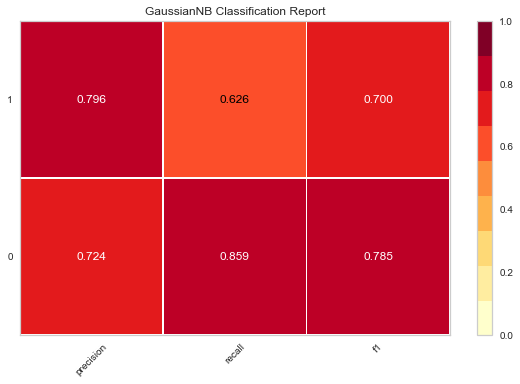

ClassificationReport(ax=<AxesSubplot:title={'center':'GaussianNB Classification Report'}>,
                     cmap=<matplotlib.colors.ListedColormap object at 0x000001DD9513D2B0>,
                     estimator=Pipeline(steps=[('impute',
                                                SimpleImputer(strategy='most_frequent')),
                                               ('clf', GaussianNB())]),
                     is_fitted=False)

In [192]:
classification_report(model5, X_train, y_train, X_test, y_test, is_fitted=False)

In [182]:
from yellowbrick.classifier import classification_report, confusion_matrix, discrimination_threshold

In [188]:
model5 = Pipeline([
    ('impute', SimpleImputer(strategy="most_frequent")),
    ('clf', GaussianNB()),
])
cross_validate(model5, X_train, y_train, cv=TimeSeriesSplit(), scoring='f1_macro')

{'fit_time': array([0.00768447, 0.00714612, 0.00597954, 0.00797439, 0.00597954]),
 'score_time': array([0.00298476, 0.00199342, 0.00298977, 0.00298905, 0.00199318]),
 'test_score': array([0.77482725, 0.72162957, 0.7445316 , 0.76957167, 0.7595667 ])}

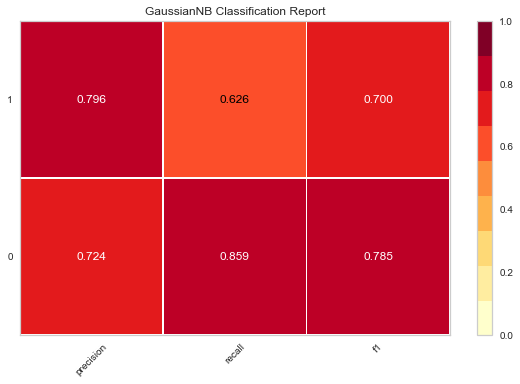

ClassificationReport(ax=<AxesSubplot:title={'center':'GaussianNB Classification Report'}>,
                     cmap=<matplotlib.colors.ListedColormap object at 0x000001DD955D5FD0>,
                     estimator=Pipeline(steps=[('impute',
                                                SimpleImputer(strategy='most_frequent')),
                                               ('clf', GaussianNB())]),
                     is_fitted=False)

In [189]:
classification_report(model5, X_train, y_train, X_test, y_test, is_fitted=False)